# Implementing SGD Using PyTorch to Solve MNIST

We'll learn more about PyTorch's classes like nn.Module and nn.Linear as we use them to implement stochastic gradient descent. We'll then train our model on the MNIST dataset.

At the end, I implement my own versions of nn.Module and nn.Linear, in order to get a better idea of how PyTorch is built. I will verify that my own implementations perform identical to PyTorch's.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai import *

## Get and Convert the Data

Get the pickled MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz

In [3]:
path = Config.data_path()/'mnist'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/mnist')

In [4]:
url = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
download_url(url,dest=path/'mnist.pkl.gz')

In [5]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

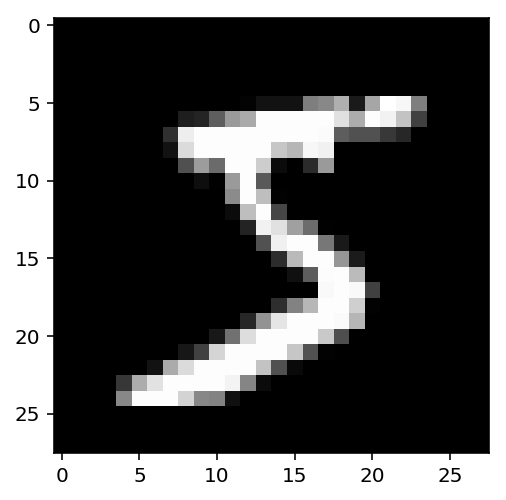

In [6]:
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
x_train.shape

In [7]:
# Store train and valid sets as torch tensors
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In the lesson2-sgd notebook we implemented SGD from scratch:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now, we'll implement the same, but using PyTorch's functions/classes. Doing this will also allow our SGD to handle mini-batches.

In [8]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [9]:
# Use generators to get each batch
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

## Create a Single Layer Network

In [10]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
    
    def forward(self, xb): return self.lin(xb)

In [11]:
model = Mnist_Logistic().cuda()

In [12]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [13]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [14]:
model(x).shape

torch.Size([64, 10])

In [15]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [16]:
lr=2e-2

In [17]:
loss_func = nn.CrossEntropyLoss()

## SGD Parameters (Weights) Update Function

In [18]:
def update(x,y,lr):
    wd = 1e-5 # weight decay multiplier
    y_hat = model(x)
    w2 = 0. # L2 reg
    for p in model.parameters(): w2 += (p**2).sum() # calculate L2 reg
    loss = loss_func(y_hat, y) + w2*wd # add weight decay to regular loss
    loss.backward() # prepare for backprop
    with torch.no_grad(): # Temporarily set all the requires_grad flags
                          # to false because we are just updating values here.
        for p in model.parameters(): # for each parameter (weight())
            p.sub_(lr * p.grad) # subtract derivative of loss times learning rate
            p.grad.zero_() # Set gradients of parameters to 0 now that 
                           # parameters have all been updated.
    return loss.item() # return just the numbers from the tensor

In [20]:
losses = [update(x,y,lr) for x,y in data.train_dl]

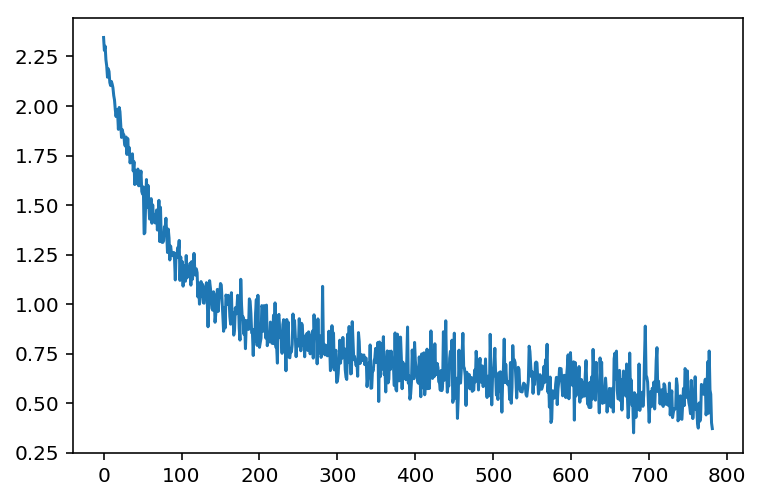

In [21]:
plt.plot(losses);

## Double Layer NN

In [19]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [20]:
model = Mnist_NN().cuda()

In [21]:
losses = [update(x,y,lr) for x,y in data.train_dl]

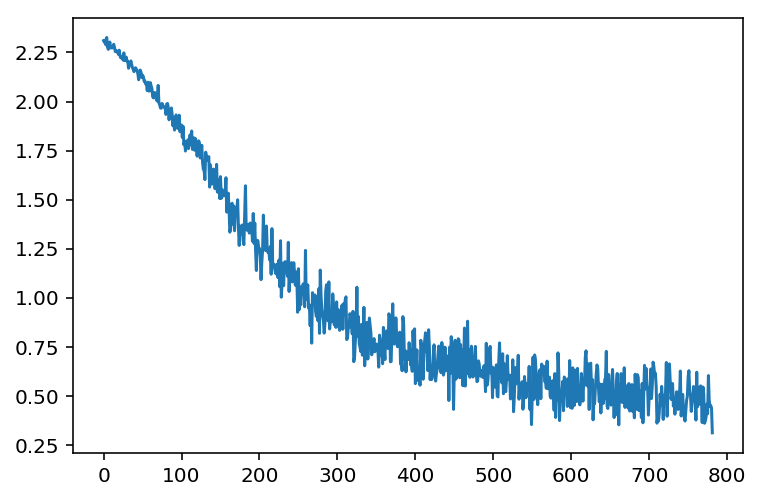

In [22]:
plt.plot(losses);

In [26]:
min(losses)

0.3118542730808258

## Adam Parameters (Weights) Update Function

This time, we write our update function using an Adam optimizer instead of SGD. However, this time we simplify things by making use of the optimizer's `.step()` method.

In [27]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [28]:
losses = [update(x,y,0.001) for x,y in data.train_dl]

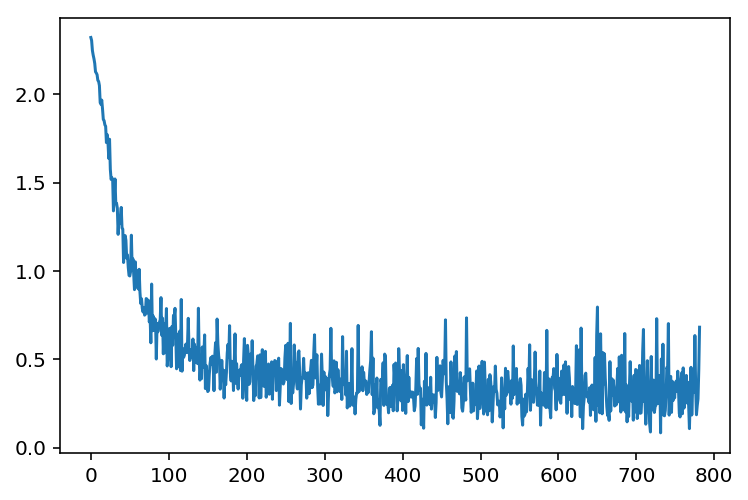

In [29]:
plt.plot(losses);

In [30]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


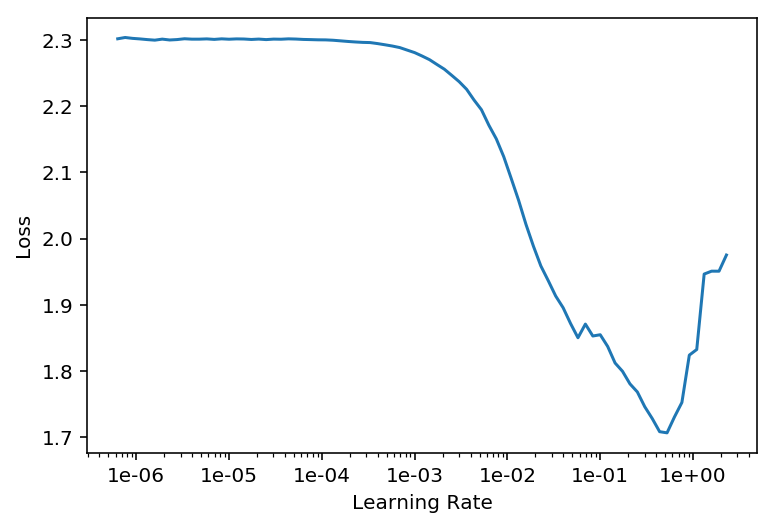

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-2)

Total time: 00:02
epoch  train_loss  valid_loss
1      0.148601    0.129497    (00:02)



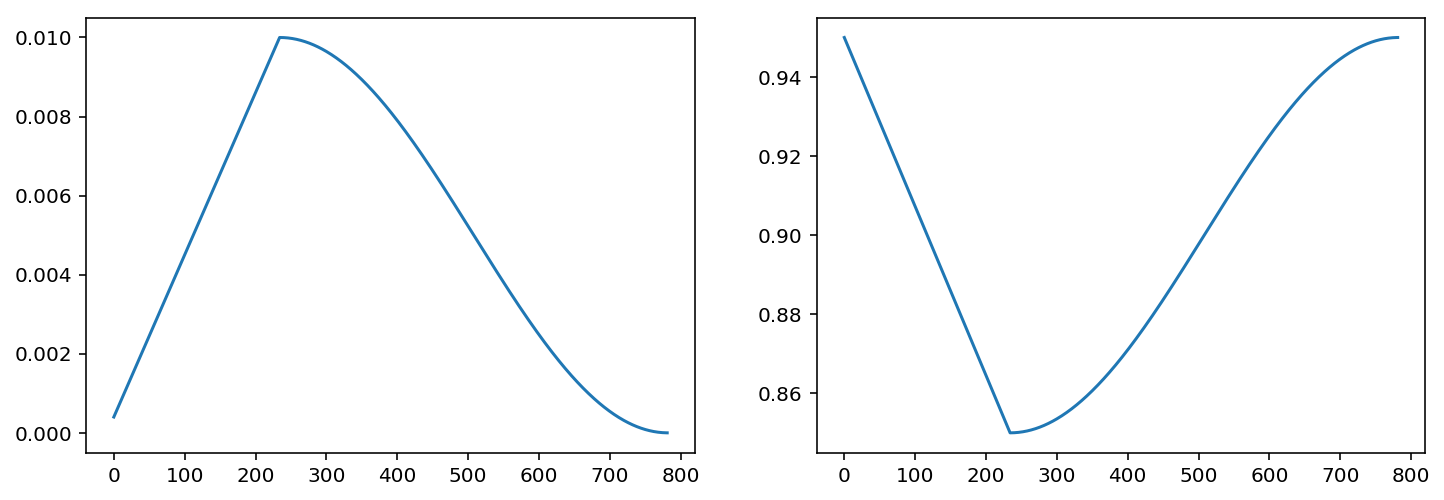

In [34]:
learn.recorder.plot_lr(show_moms=True)

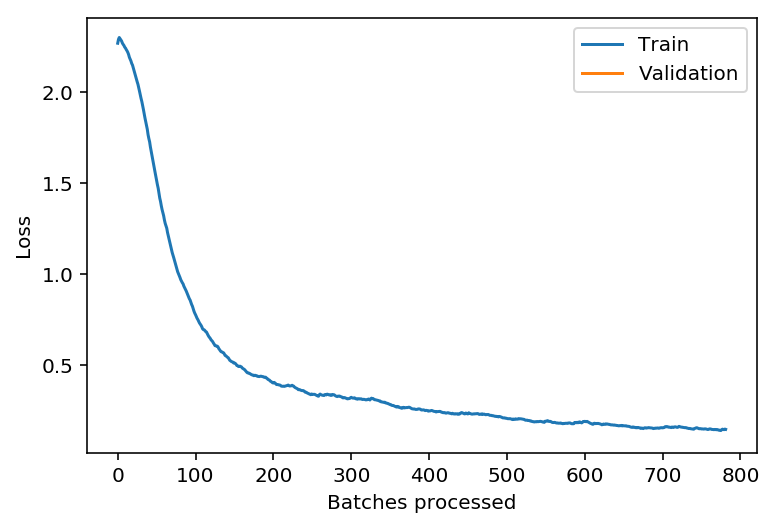

In [35]:
learn.recorder.plot_losses()

## Implementing my own version of nn.Linear from scratch

### myLinear

In [39]:
from torch.nn.parameter import Parameter

class myLinear(nn.Module):
    def __init__(self, x_size, y_size, has_bias=True):
        super(myLinear, self).__init__()
        self.x_size = x_size
        self.y_size = y_size
        self.has_bias = has_bias
        self.a = Parameter(torch.Tensor(x_size, y_size)) 
        stddev = 1./math.sqrt(self.a.size(1))
        self.a.data.uniform_(-stddev, stddev)
        if self.has_bias:
            self.b = Parameter(torch.Tensor(y_size))
            self.b.data.uniform_(-stddev,stddev)
        
    def forward(self, x):
        if self.has_bias:
            return x@self.a + self.b
        else:
            return x@self.a

### Verify my version's results as good or better than those we saw above with PyTorch's nn.Linear class:

### Double Layer NN

In [40]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = myLinear(784, 50, has_bias=True)
        self.lin2 = myLinear(50, 10, has_bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [41]:
model = Mnist_NN().cuda()

In [42]:
losses = [update(x,y,lr) for x,y in data.train_dl]

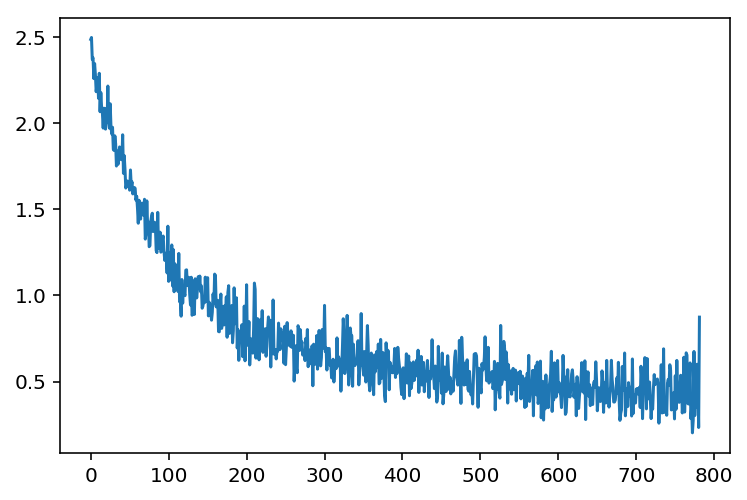

In [43]:
plt.plot(losses);

In [44]:
min(losses)

0.202508345246315

## Conclusion

Using PyTorch's nn.Linear class in my double layer NN (Mnist_NN) above got a minimum loss of `0.31185`. Using the myLinear class that I made got a minimum loss of `0.20251`.